In [48]:
%matplotlib inline
import numpy as np
import pypico
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner
from astropy.cosmology import LambdaCDM
import astropy.units as u

In [49]:
# Load datas

# Note i didn't upload the data file to github as it's too large
# comment my path and change to your own path to see data

# pico data on pypico's github
pico = pypico.load_pico("../data/jcset_py3.dat")


# CMB data
# FROM: http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt
df = pd.read_table('../data/COM_PowerSpect_CMB-TT-full_R3.01.txt', skiprows=1, names=['l', 'Dl', '-dDl', '+dDl'], delimiter='  ')
# make df with col0: x;     col1: y;    col2:y_err     
df['Dl_err'] = (df['+dDl'] + df['-dDl'])/2
df = df.drop(columns=['+dDl','-dDl'])


# sne data from lab 2
df_sne = pd.read_csv('../data/SCPUnion2.1_mu_vs_z.txt', names =['Event','z','dm','dm_err','prob'], header = None, skiprows=5, sep='\t')
df_sne = df_sne.drop(columns=['Event', 'prob'])


# above drop columns to keep all dataframe as same format

/var/folders/_2/d0xmq0nn39z8s3ccvbbr049h0000gn/T/ipykernel_3040/8877297.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_table('../data/COM_PowerSpect_CMB-TT-full_R3.01.txt', skiprows=1, names=['l', 'Dl', '-dDl', '+dDl'], delimiter='  ')


In [50]:
# example parameters from pypico
As = 2e-9
ns = 0.97
tau = 0.055
ombh2 = 0.0225
omch2 = 0.117
H0 = 65

omk = 0
pivot_scalar = 0.05

theta = (As, ns, tau, ombh2, omch2, H0)
labels=['As', 'ns', 'tau', 'ombh2', 'omch2', 'H0']

note that
\begin{equation}
D_l = C_{l}\frac{l(l + 1)}{2\pi}
\end{equation}

In [51]:
def model_CMB(theta, omk=0, pico=pico):
    '''
    generate data for power spectrum

    param:
        theta: parameters for the model
        pico: pico object as a modle generator
    return:
        dl_TT: result of Dl_model data
    '''
    #load our input dire
    As, ns, tau, ombh2, omch2, H0 = theta
    input_dir = {'As': As,
                'ns': ns,
                'tau': tau,
                'ombh2': ombh2,
                'omch2': omch2,
                'H0': H0,
                'omk': omk}

    result = pico.get(**input_dir, force=True)      # set True as we will use MCMC
    dl_TT = result['dl_TT']

    # note: the pico.outputs() gives ['cl_TT']; the result above gives ['dl_TT']
    # do i have to transfer as above?
    #cl_TT = [dl_TT[i]*2*np.pi/(i*(i+1)) for i in range(len(dl_TT))]

    return dl_TT


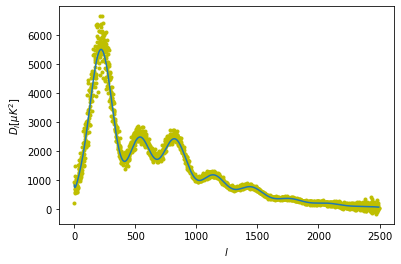

In [52]:
# just to see the example data to make sure we are on the right track
dl = model_CMB(theta)
dl = dl[2:]

plt.scatter(df['l'][:len(dl)], df['Dl'][:len(dl)], c='y', marker='.')
plt.plot(df['l'][:len(dl)], dl)
plt.xlabel("$l$")
plt.ylabel("$D_{l} [\mu K^2]$")
plt.show()


In [53]:
# helper function for MCMC posterior

def log_prior(theta):
    As, ns, tau, ombh2, omch2, H0 = theta
    if (1e-9 < As < 5e-9 and .5 < ns < 1.5 and -.5 < tau < .5 and 0 < ombh2 < .5 and -.1 < omch2 < .2 and 0 < H0 < 150):
        return 0
    return -np.inf


def log_likeli(theta, df=df):
    #load data
    dmodel = model_CMB(theta)
    data = df.copy()

    # keep l of model and data the same
    dmodel = dmodel[2:]
    if len(dmodel) < len(data):
        data = data[:len(dmodel)]
    else:
        dmodel = dmodel[:len(data)]

    sigma2 = data['Dl_err']**2
    return -0.5 * np.sum((data['Dl']-dmodel)**2 / sigma2 + np.log(sigma2))


def log_post(theta, df=df):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likeli(theta, df=df)

In [54]:
def MCMC(theta, posterier=log_post, nwalkers=30, num_iter=4500):
    '''
    generate the sample data for the MCMC model

    param:
        theta: parameters for the model
        posterior: posterior function that take theta as input
        nwalkers: number of walkers
        num_iter: total iteration number
    return:
        sampler from the emcee package
    '''
    ndim = len(theta)
    pos = 0.01*np.random.rand(nwalkers, ndim)+.995
    for i in range(ndim):
        pos[:, i] *= theta[i]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, posterier)
    sampler.run_mcmc(pos, num_iter, progress=True)
    
    return sampler

In [55]:
def plot_generator(sampler, df=df, labels=labels,  model=model_CMB, is_CMB=True, show_coner=True, show_trace=True, show_mult_sample=True, show_mean=True ):
    '''
    generate plots and show results

    param:
        sampler: sample data for the MCMC model
        df: dataFtrame contain our raw data
        labels: parameter names
        model: model we use that take theta as input
        is_CMB: if we want to genrate plots for cmb
        show_coner: if you want the coner plot
        show_trace: if you want the trace plot
        show_mult_sample: if you want the plot with different theta
        show_mean: if you want the mean theta plot
    return:
        flat sample
    '''
    samples = sampler.get_chain()
    flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

    # err_bar = np.std(flat_samples, axis=0)
    mean_param = np.mean(np.mean(samples, axis=0), axis=0)
    dl = model(mean_param)
    # make the size of model and data the same
    if is_CMB:
        dl = dl[2:]
    if len(df) > len(dl):
        df=df[:len(dl)]
    else:
        dl=dl[:len(df)]

    x = df.iloc[:, 0]
    y = df.iloc[:, 1]
    y_err = df.iloc[:, 2]


    def plot_corner():
        corner.corner(flat_samples, bins=20, labels=labels, quantiles=[0.16, 0.5, 0.84])


    def plot_trace(ndim = len(labels)):
        _, axes = plt.subplots(ndim, figsize=(30, 30), sharex=True)
        samples = sampler.get_chain()
        for i in range(ndim):
            ax = axes[i]
            ax.plot(samples[:, :, i], alpha=0.3)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[i])
        axes[-1].set_xlabel("Step number")


    def plot_multi_sample(size=100):
        inds = np.random.randint(len(flat_samples), size=size)

        plt.figure(figsize=(12, 5))
        plt.scatter(x, y, marker='.')
        for ind in inds:
            s = flat_samples[ind]
            if is_CMB:
                dl_s = model(s)[2:]
            else:
                dl_s = model(s)
            if len(dl_s)>len(df):
                dl_s = dl_s[:len(df)]
            plt.plot(x, dl_s, 'r', alpha=0.1)
        if not is_CMB:
            plt.xscale('log')
        plt.show()


    def plot_mean():
        plt.figure(figsize=(12, 5))
        plt.errorbar(x, y, yerr=y_err, fmt=".", alpha=0.1)
        plt.plot(x, dl)
        if not is_CMB:
            plt.xscale('log')
        plt.show()
        

    if show_coner:
        plot_corner()
    if show_trace:
        plot_trace()
    if show_mult_sample:
        plot_multi_sample()
    if show_mean:
        plot_mean()
    
    return flat_samples


## full L

In [56]:
# full L
theta = (As, ns, tau, ombh2, omch2, H0)
sampler = MCMC(theta, posterier=log_post)

100%|██████████| 4500/4500 [02:48<00:00, 26.71it/s]


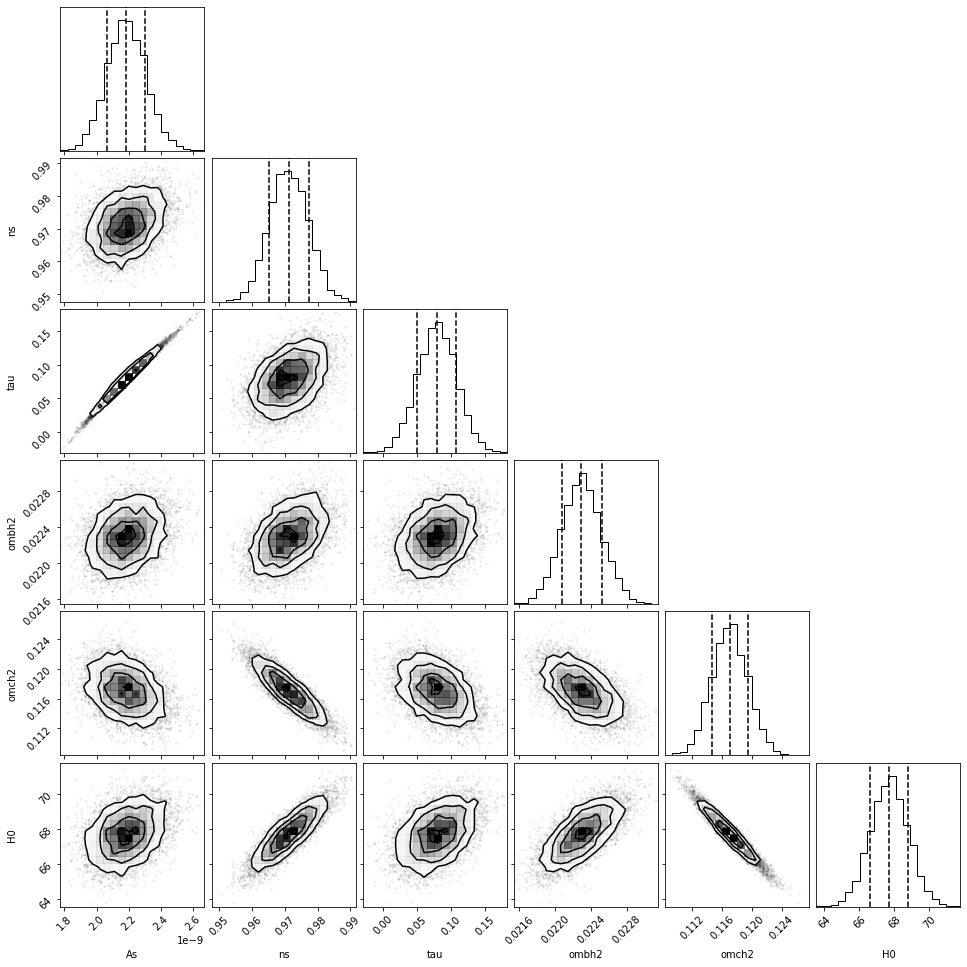

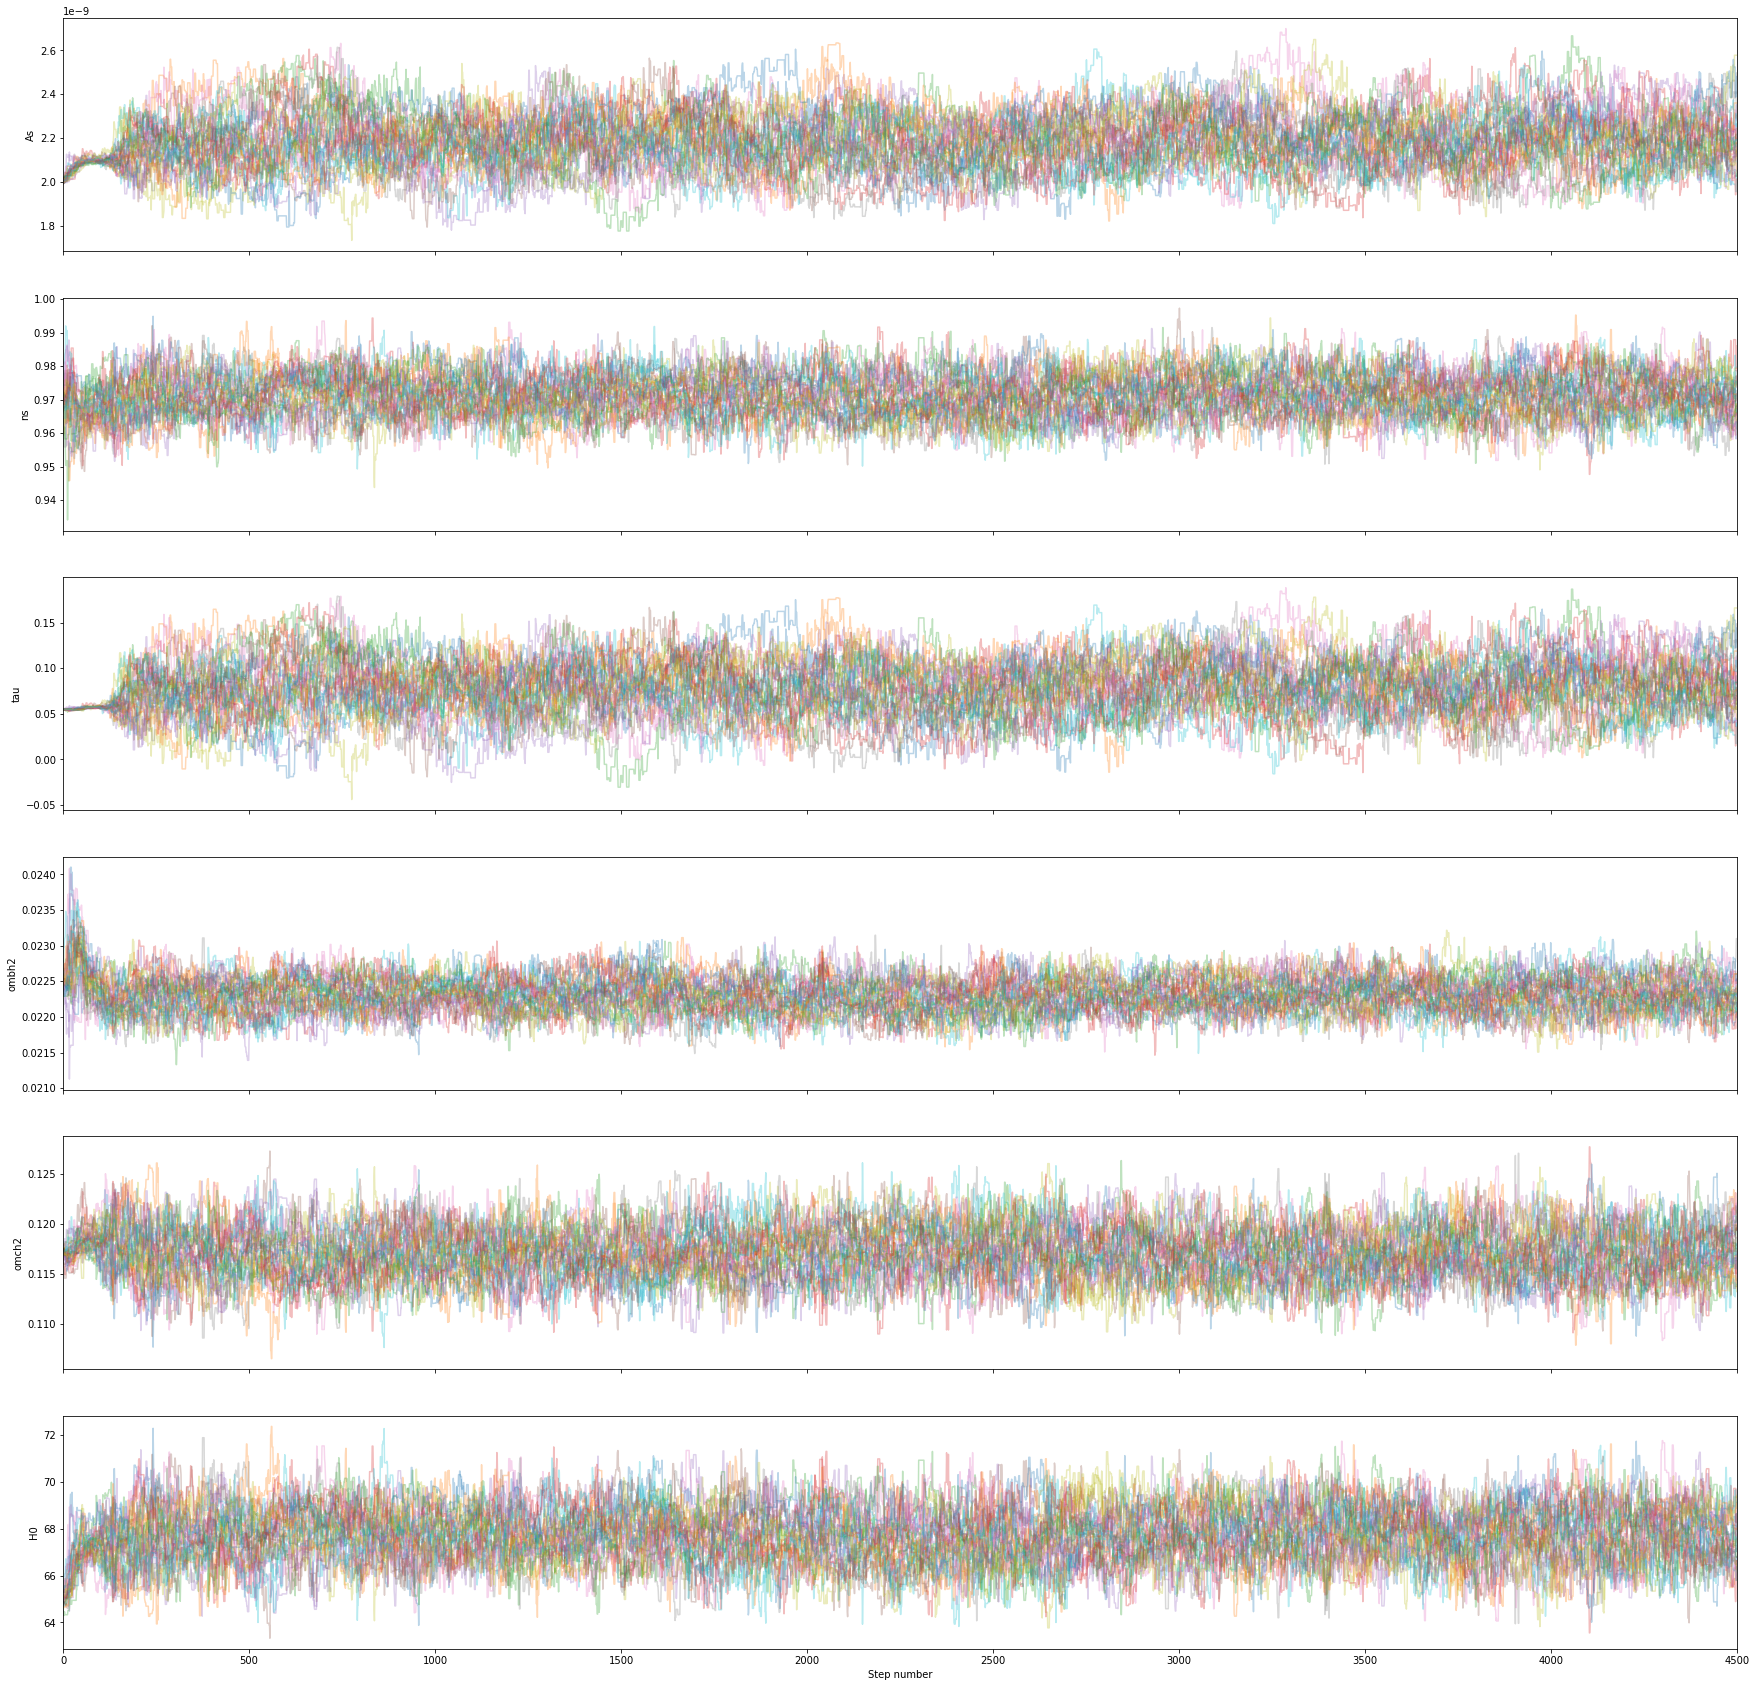

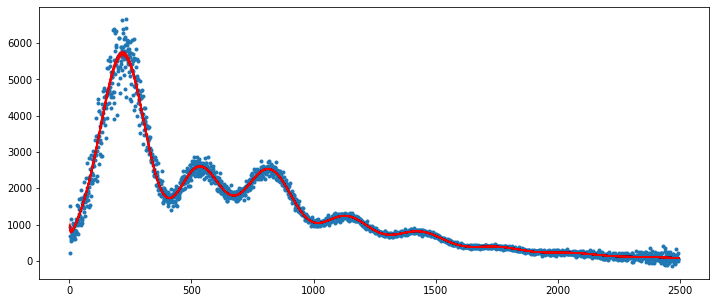

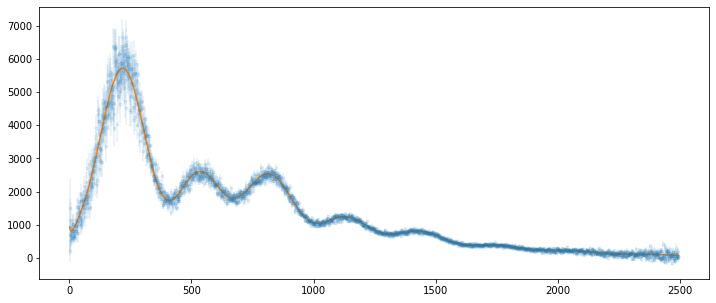

In [58]:
sample_full = plot_generator(sampler, df=df, labels=labels)

## Compare L's and uncertainty of H0

In [88]:
df_H0_err = pd.DataFrame(columns=['use_rows', 'H0', 'H0_err'])
df_tmp = df.copy()

while(len(df_tmp) > 100):
    log_post_tmp = lambda t: log_post(t, df_tmp)
    sampler_tmp = MCMC(theta, posterier=log_post_tmp, num_iter=2000)

    sample_tmp = sampler_tmp.get_chain(discard=700, thin=15, flat=True)

    mean_tmp = np.mean(sample_tmp, axis=0)[-1]
    err_tmp = np.std(sample_tmp, axis=0)[-1]

    df_tmp = df_tmp[:int(len(df_tmp)//1.5)]
    df_H0_err.loc[len(df_H0_err)] = [len(df_tmp), mean_tmp, err_tmp]

df_H0_err

100%|██████████| 2000/2000 [01:00<00:00, 33.04it/s]


use_rows         H0     H0_err
0    1671.0  67.675586   1.086271
1    1114.0  68.588231   1.285906
2     742.0  70.691662   1.653819
3     494.0  72.001575   2.717070
4     329.0  72.171847   4.397727
5     219.0  70.080949   4.295670
6     146.0  71.525565   9.276080
7      97.0  64.557295  15.223931

Text(0.5, 0, 'rows of data used')

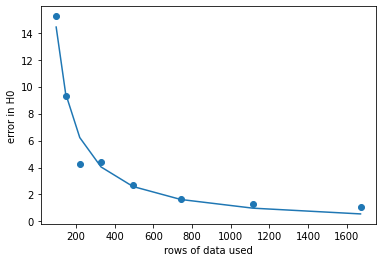

In [177]:
from scipy.optimize import curve_fit

rows = df_H0_err['use_rows']
# we should use reverse exponential here, but got some bugs with curve_fit
rev_ratio = lambda x, a, b: a/x+b
popt, _ = curve_fit(rev_ratio, rows, df_H0_err['H0_err'])
f = lambda x: rev_ratio(x, popt[0], popt[1])

plt.plot(rows, f(rows))
plt.scatter(rows, df_H0_err['H0_err'], marker='o')
plt.ylabel('error in H0')
plt.xlabel('rows of data used')

## SNe data


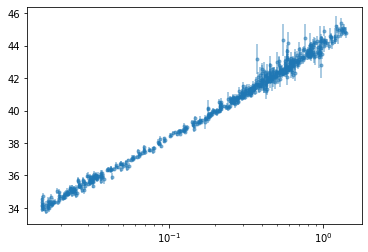

z         dm    dm_err
0  0.028488  35.346583  0.223906
1  0.050043  36.682368  0.166829
2  0.052926  36.817691  0.155756
3  0.070086  37.446737  0.158467
4  0.062668  37.483409  0.156099

In [178]:
# just plot the example data to make sure we are on the right track
plt.errorbar(df_sne['z'], df_sne['dm'], yerr=df_sne['dm_err'],fmt='.', alpha=0.5)
plt.xscale('log')
plt.show()

df_sne[:5]

In [179]:
def model_sne(theta, df=df_sne):
    '''
    generate data for power spectrum

    param:
        theta: parameters for the model
    return:
        model data
    '''
    H0, Om0, Ode0 = theta
    model = LambdaCDM(H0=H0, Om0=Om0, Ode0=Ode0).distmod(df['z']).value
    return model

In [180]:
# helper function for MCMC posterior
def log_prior_sne(theta):
    H0, Om0, Ode0 = theta
    if 50 < H0 < 100 and 0.0 < Om0 < 0.6 and 0.1 < Ode0 < 1.2:
        return 0.0
    return -np.inf

def log_likeli_sne(theta, df=df_sne):
    model = model_sne(theta, df=df)
    sigma2 = df['dm_err'] ** 2
    return -0.5 * np.sum((df['dm'] - model) ** 2 / sigma2 + np.log(sigma2)) 

def log_post_sne(theta, df=df_sne):
    lp = log_prior_sne(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_likeli_sne(theta, df)

In [182]:
# initial guess
H0 = 70
om0 = 0.3
ode0 = 0.7
theta = (H0, om0, ode0)
labels=['H0', 'Om0', 'Ode0']

sampler_sne = MCMC(theta, posterier=log_post_sne, num_iter=3500)

100%|██████████| 3500/3500 [02:23<00:00, 24.36it/s]


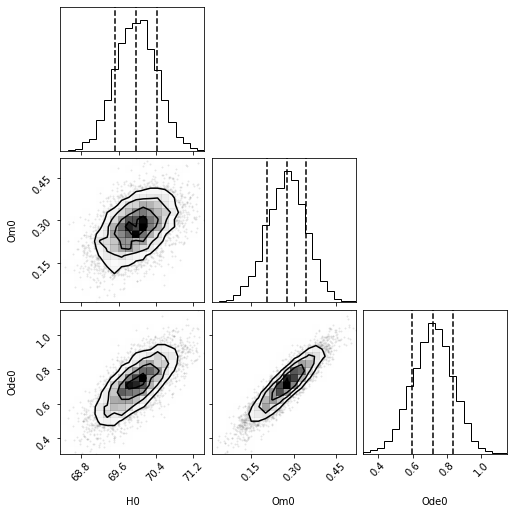

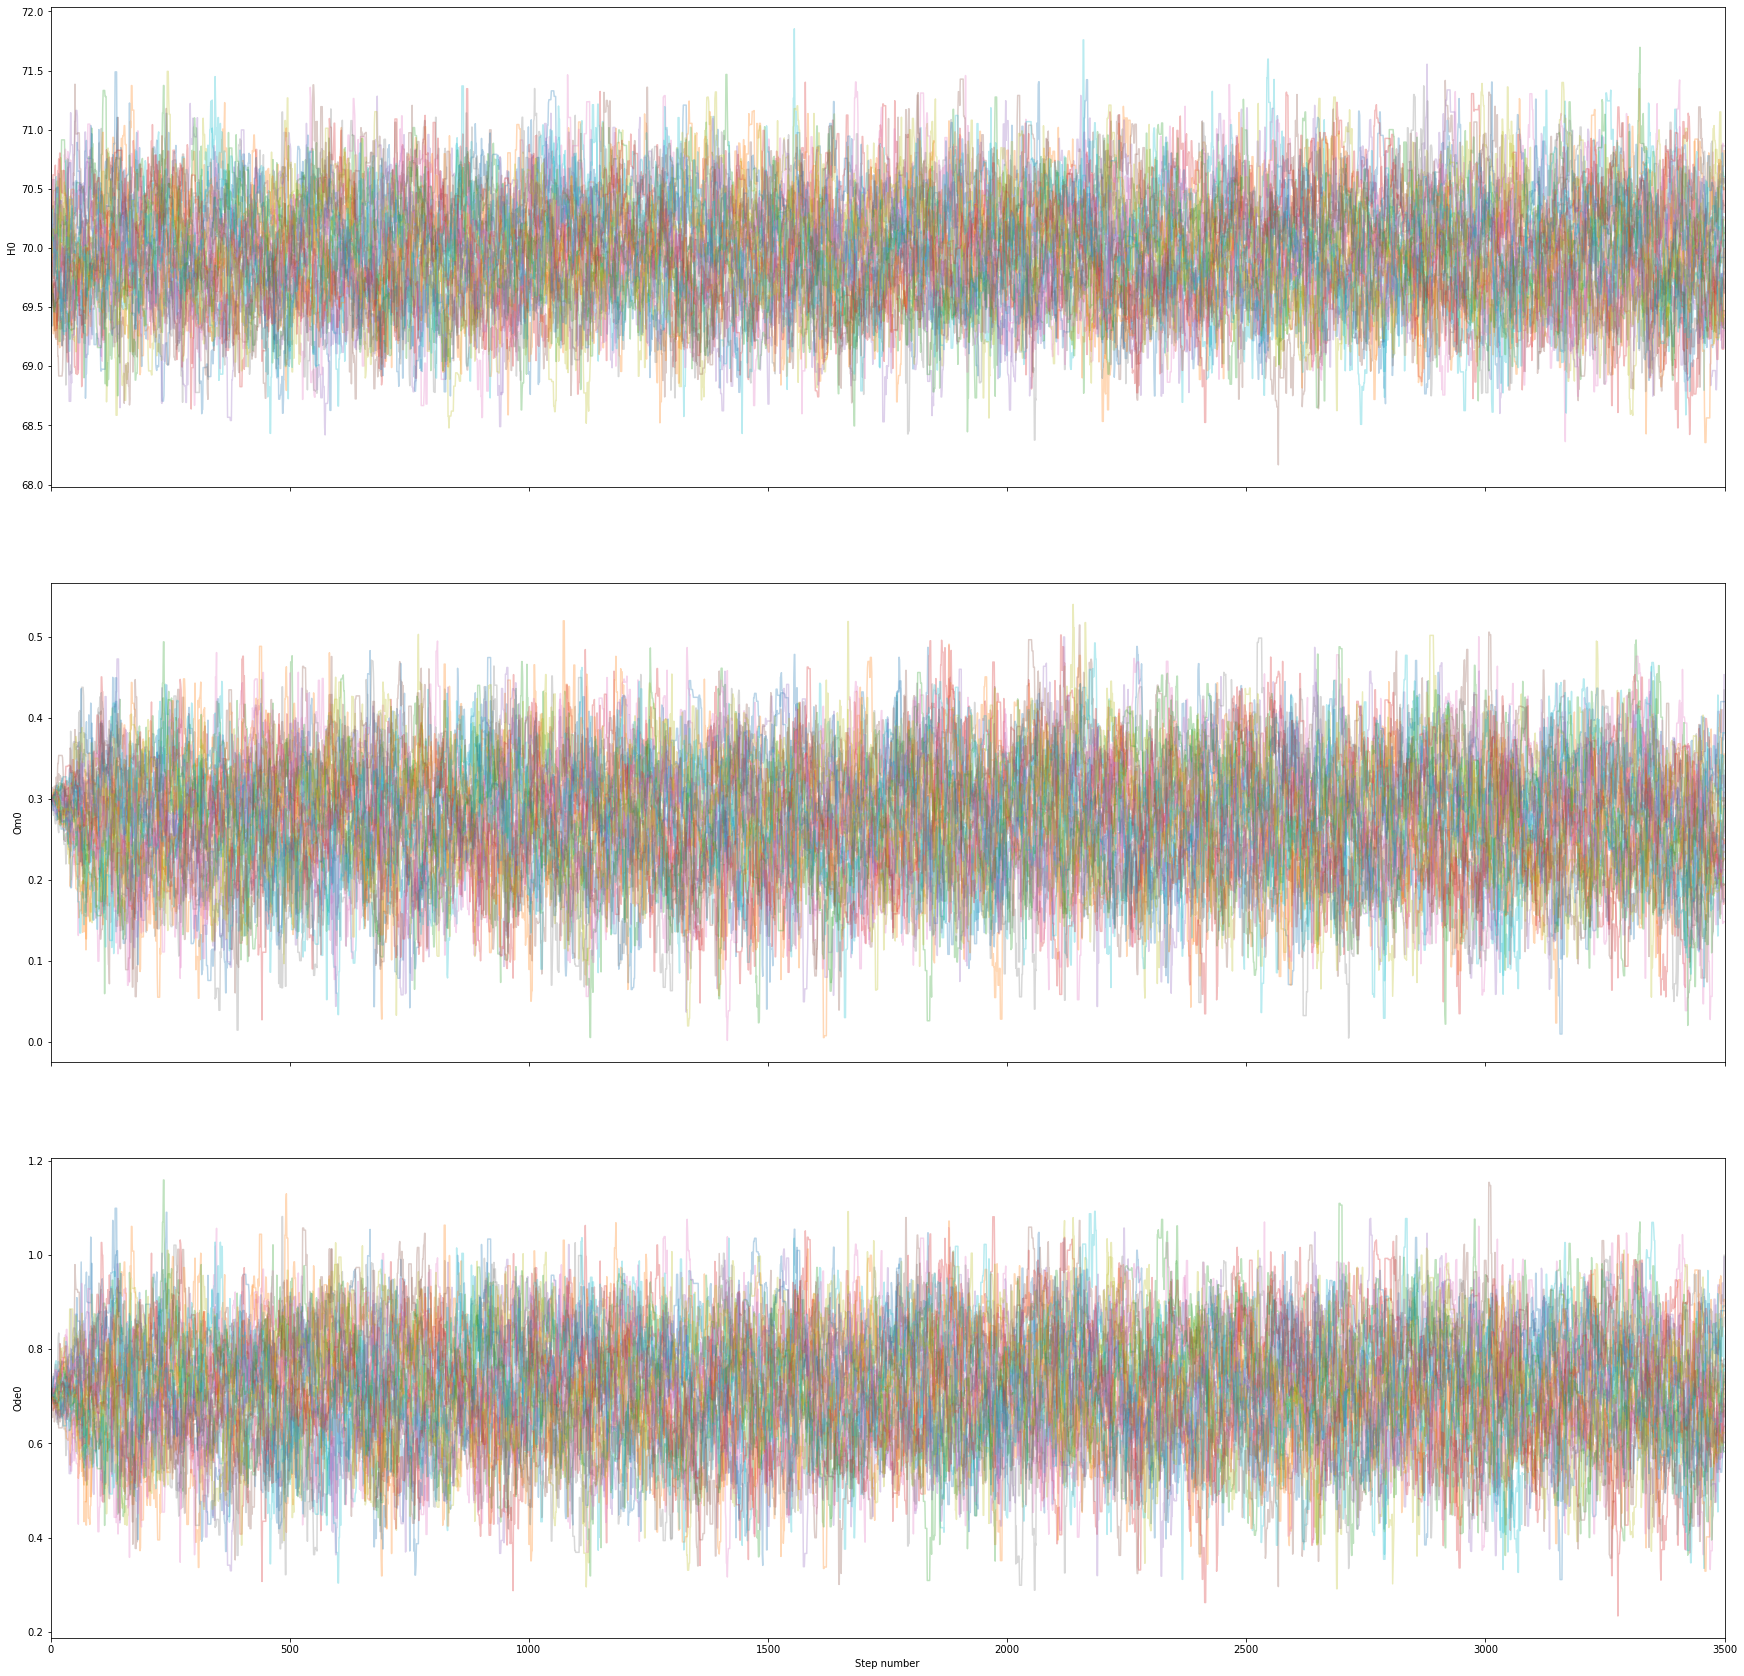

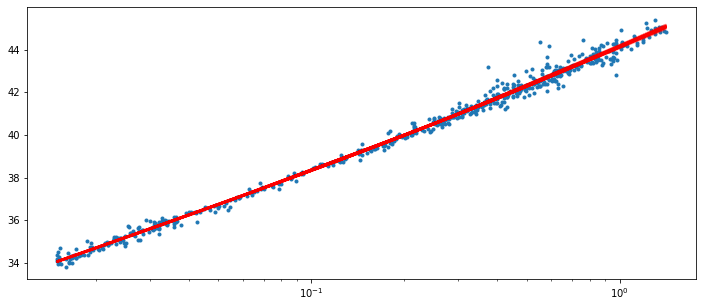

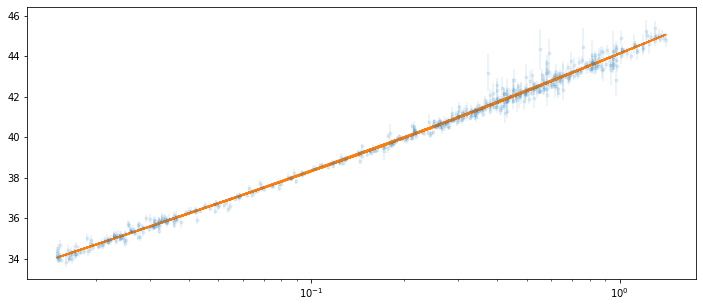

In [183]:
sample_sne = plot_generator(sampler_sne, df=df_sne, labels=labels, model=model_sne, is_CMB=False)

# Combine CMB and SNe

In [186]:
H0_CMB = sample_full[:, -1]
H0_SNe = sample_sne[:, 0]

H0_CMB, H0_SNe

(array([68.28080489, 68.46196558, 67.49261043, ..., 66.89421266,
        68.68761953, 67.55077444]),
 array([69.58416091, 70.21493073, 69.62467695, ..., 70.51637958,
        69.24108223, 70.33773947]))

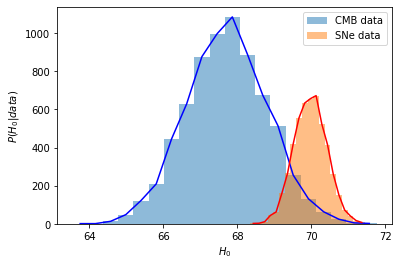

In [215]:
p_cmb, bin_cmb,_ = plt.hist(H0_CMB, bins=20, label='CMB data', alpha=0.5)
p_sne, bin_sne,_ = plt.hist(H0_SNe, bins=20, label='SNe data', alpha=0.5)
bin_cmb = (bin_cmb[:-1]+bin_cmb[1:])/2
bin_sne = (bin_sne[:-1]+bin_sne[1:])/2

plt.plot(bin_cmb, p_cmb, 'blue')
plt.plot(bin_sne, p_sne, 'red')
plt.ylabel('$P(H_0 | data)$')
plt.xlabel('$H_0$')
plt.legend()